In [1]:
%matplotlib inline

# General packages for system, time, etc
import os, time, csv
import datetime
from datetime import date
import glob
import feather  # for compiling files

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

# parallel processing related
from p_tqdm import p_map
from functools import partial

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


The current HDDM version is:  0.8.0
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.11.4


In [2]:
from HDDMarviz import HDDMarviz

In [3]:
data_cavanagh = hddm.load_csv(os.path.join(os.path.dirname(hddm.__file__), 
                                           'examples', 
                                           'cavanagh_theta_nn.csv'))
data_cavanagh.tail()

,subj_idx,stim,rt,response,theta,dbs,conf
3983,13,LL,1.450,0.0,-1.237166,0,HC
3984,13,WL,0.711,1.0,-0.377450,0,LC
3985,13,WL,0.784,1.0,-0.694194,0,LC
3986,13,LL,2.350,0.0,-0.546536,0,HC
3987,13,WW,1.250,1.0,0.752388,0,HC


In [4]:
%%time

# define a function to run model in parallel

# M0_0: base model: simplified
def ms0(id, df=None, samples=None, burn=None, thin=1, save_name="ms0"): 
    # for HDDM models, adding this print func can prevent warnings that would occur
    #  when running parallel processing in jupyter
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df)
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M1: base model: full model
def ms1(id, df=None, samples=None, burn=None, thin = 1, save_name="ms1"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, include=['z', 'sv', 'sz', 'st'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m


# M2: treat within-subj as between-subj: full model
def ms2(id, df=None, samples=None, burn=None, thin = 1, save_name="ms2"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, include=['z', 'sv', 'st', 'sz'], 
                  depends_on={'v': 'conf'})
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m


# M3: regression model (varying intercept)
def ms3(id, df=None, samples=None, burn=None, thin = 1, save_name="ms3"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id   
    m = hddm.HDDMRegressor(df,  
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=True,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M4: regression model (varying intercept and slope)
def ms4(id, df=None, samples=None, burn=None, thin = 1, save_name="ms4"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id   
    m = hddm.HDDMRegressor(df,
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M5: regression model + theta as an additional predictor of `a`
def ms5(id, df=None, samples=None, burn=None, thin = 1, save_name="ms5"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    m = hddm.HDDMRegressor(df,
                           "a ~ theta:C(conf, Treatment('LC'))",
                           depends_on={'v': 'conf'},
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M6: Regression for both parameters
def ms6(id, df=None, samples=None, burn=None, thin = 1, save_name="ms6"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    a_reg = {'model': "a ~ theta:C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    v_reg = {'model': "v ~ C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    reg_descr = [a_reg, v_reg]
    
    m = hddm.HDDMRegressor(df,
                           reg_descr,
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M7: Regression for both parameters
def ms7(id, df=None, samples=None, burn=None, thin = 1, save_name="ms7"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    a_reg = {'model': "a ~ theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))", 'link_func': lambda x: x}
    v_reg = {'model': "v ~ C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    reg_descr = [a_reg, v_reg]
    
    m = hddm.HDDMRegressor(df,
                           reg_descr,
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 8.34 µs


In [5]:
samples = 300  # Cavanagh et al. 2011 used 30,000 and 10, 000 burn.
burn = 100     
nppc = 50     # 1000 samples for posterior predictive, super slow
thin = 1
chains = 4
test_mode = False
savefile=True
savetag = "tmp"

In [6]:
%%time

## total time: 5h 19s when test_mode is False

## Step 1: run models in parallel
file_path = "/home/jovyan/hddm/temp/"

if test_mode:
    model_func = ms0

else: 
    model_func = [ms0,  
                  ms4]

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 6.91 µs


In [7]:
callable(model_func)

False

note: here we have problems when running parallel processing in jupyter, the issue here is similar to here: https://github.com/tqdm/tqdm/issues/485. I need to figure it out which function can be hacked with `print()`.

Note: when model is ms0, there will be a warning about msg_id

In [8]:
# model = model_func[0]
# m_key = model.__name__  # get the model function's name
# save_name_m = m_key + "_" + savetag
# print(save_name_m)

# ms_tmp = p_map(partial(model,
#                        df=data_cavanagh, 
#                        samples=samples,
#                        burn=burn,
#                        thin=thin, 
#                        save_name=save_name_m),
#                    range(chains))

# xdata_post_pred = [] # define an empty dict    

# xdata_post_pred = p_map(partial(post_pred_gen, samples = nppc), models['ms0'])

In [9]:
models, InfData = HDDMarviz(data=data_cavanagh, 
                            model_func=model_func,
                            samples=samples, 
                            nppc=nppc, 
                            burn=burn, 
                            thin=thin, 
                            chains=chains, 
                            savefile=savefile,
                            savetag=savetag)

start model fitting for ms0
running chain 0 for model ms0_tmp

running chain 2 for model ms0_tmprunning chain 1 for model ms0_tmp

  0%|          | 0/4 [00:00<?, ?it/s]


running chain 3 for model ms0_tmp


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 -                 4%                  ] 12 of 300 complete in 0.5 secc [-                 4%                  ] 13 of 300 complete in 0.5 sec[-                 4%                  ] 12 of 300 complete in 0.5 sec[--                7%                  ] 23 of 300 complete in 1.0 sec[---               8%                  ] 24 of 300 complete in 1.0 sec[--                7%                  ] 23 of 300 complete in 1.0 sec[---               8%                  ] 24 of 300 complete in 1.1 sec[----             11%                  ] 35 of 300 complete in 1.5 sec[----             11%                  ] 34 of 300 complete in 1.5 sec[----             12%                  ] 36 of 300 complete in 1.6 sec[----             11%                  ] 35 of 300 complete in 1.6 sec[-----            15%                  ] 45 of 300 complete in 2.0 sec[-----            15%                  ] 47 of 300 complete in 2.1 sec[-----            15%                  ] 47 of 300 complete in 2.1 sec[-----            

  0%|          | 0/4 [00:00<?, ?it/s]

started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
 [----------       28%                  ] 4 of 14 complete in 0.7 sec[----------       28%                  ] 4 of 14 complete in 0.6 sec[----------       28%                  ] 4 of 14 complete in 0.6 sec[----------       28%                  ] 4 of 14 complete in 0.6 sec[-------------    35%                  ] 5 of 14 complete in 1.3 sec[-------------    35%                  ] 5 of 14 complete in 1.3 sec[-------------    35%                  ] 5 of 14 complete in 1.3 sec[-------------    35%                  ] 5 of 14 complete in 1.3 sec[---------------- 42%                  ] 6 of 14 complete in 1.9 sec[---------------- 42%                  ] 6 of 14 complete in 2.0 sec[---------------- 42%                  ] 6 of 14 complete in 1.9 sec[---------------- 42%                  ] 6 of 14 complete in 1.9 sec[--------------

  0%|          | 0/4 [00:00<?, ?it/s]

started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
 [-----------------71%-------           ] 10 of 14 complete in 0.6 sec[-----------------64%----              ] 9 of 14 complete in 0.5 sec[-----------------71%-------           ] 10 of 14 complete in 0.6 sec[-----------------71%-------           ] 10 of 14 complete in 0.6 sec[-----------------100%-----------------] 14 of 14 complete in 1.0 sec[-----------------100%-----------------] 14 of 14 complete in 1.0 sec[-----------------100%-----------------] 14 of 14 complete in 1.0 sec[-----------------100%-----------------] 14 of 14 complete in 1.0 sec[---------------------121%---------------------] 17 of 14 complete in 1.1 sec[-------------------114%--------------------] 16 of 14 complete in 1.1 sec[---------------------121%---------------------] 17 of 14 complete in 1.1 sec[---------------------121%---------------------] 17 

  0%|          | 0/4 [00:00<?, ?it/s]


Adding these covariates:
['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]
running chain 2 for model ms4_tmp
Adding these covariates:
['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]
running chain 3 for model ms4_tmp
running chain 1 for model ms4_tmp
Adding these covariates:
['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]
Adding these covariates:
['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 --                7%                  ] 22 of 300 complete in 22.2 sec                  0%                  ] 2 of 300 complete in 0.9 sec[                  0%                  ] 2 of 300 complete in 1.0 sec[                  0%                  ] 2 of 300 complete in 0.9 sec[                  1%                  ] 3 of 300 complete in 1.8 sec[                  1%                  ] 3 of 300 complete in 1.9 sec[                  1%                  ] 3 of 300 complete in 2.0 sec[                  1%                  ] 3 of 300 complete in 1.9 sec[                  1%                  ] 4 of 300 complete in 2.9 sec[                  1%                  ] 4 of 300 complete in 2.9 sec[                  1%                  ] 4 of 300 complete in 2.9 sec[                  1%                  ] 4 of 300 complete in 3.1 sec[                  1%                  ] 5 of 300 complete in 3.8 sec[                  1%                  ] 5 of 300 complete in 4.0 sec[                  1%            

 [---              10%                  ] 31 of 300 complete in 31.4 sec[----             10%                  ] 32 of 300 complete in 31.5 sec[----             10%                  ] 32 of 300 complete in 31.5 sec[---              10%                  ] 31 of 300 complete in 31.5 sec[----             11%                  ] 33 of 300 complete in 32.4 sec[----             11%                  ] 33 of 300 complete in 32.5 sec[----             10%                  ] 32 of 300 complete in 32.5 sec[----             10%                  ] 32 of 300 complete in 32.5 sec[----             11%                  ] 34 of 300 complete in 33.6 sec[----             11%                  ] 34 of 300 complete in 33.6 sec[----             11%                  ] 33 of 300 complete in 33.6 sec[----             11%                  ] 33 of 300 complete in 33.6 sec[----             11%                  ] 35 of 300 complete in 34.6 sec[----             11%                  ] 35 of 300 complete in 34.7 sec[----

 [-------          19%                  ] 59 of 300 complete in 64.2 sec[-------          19%                  ] 59 of 300 complete in 64.5 sec[-------          20%                  ] 62 of 300 complete in 64.6 sec[-------          20%                  ] 62 of 300 complete in 65.1 sec[-------          20%                  ] 60 of 300 complete in 65.6 sec[-------          20%                  ] 60 of 300 complete in 65.7 sec[-------          21%                  ] 63 of 300 complete in 65.7 sec[-------          21%                  ] 63 of 300 complete in 66.2 sec[-------          20%                  ] 61 of 300 complete in 66.8 sec[--------         21%                  ] 64 of 300 complete in 66.7 sec[-------          20%                  ] 61 of 300 complete in 67.0 sec[--------         21%                  ] 64 of 300 complete in 67.3 sec[-------          20%                  ] 62 of 300 complete in 67.8 sec[--------         21%                  ] 65 of 300 complete in 67.9 sec[----

 [-----------      30%                  ] 92 of 300 complete in 96.7 sec[-----------      30%                  ] 90 of 300 complete in 97.0 sec[-----------      29%                  ] 87 of 300 complete in 97.1 sec[-----------      29%                  ] 89 of 300 complete in 97.3 sec[-----------      30%                  ] 91 of 300 complete in 97.9 sec[-----------      31%                  ] 93 of 300 complete in 97.9 sec[-----------      29%                  ] 88 of 300 complete in 98.3 sec[-----------      30%                  ] 90 of 300 complete in 98.4 sec[-----------      31%                  ] 94 of 300 complete in 99.0 sec[-----------      30%                  ] 92 of 300 complete in 99.2 sec  [-----------      30%                  ] 91 of 300 complete in 99.5 sec[-----------      29%                  ] 89 of 300 complete in 99.5 sec[-----------      31%                  ] 93 of 300 complete in 100.2 sec[------------     31%                  ] 95 of 300 complete in 100.0 sec[

 [--------------   38%                  ] 115 of 300 complete in 128.6 sec[--------------   39%                  ] 118 of 300 complete in 128.8 sec[---------------  40%                  ] 121 of 300 complete in 128.9 sec[--------------   39%                  ] 117 of 300 complete in 129.6 sec[--------------   38%                  ] 116 of 300 complete in 129.7 sec[---------------  39%                  ] 119 of 300 complete in 130.0 sec[---------------  40%                  ] 122 of 300 complete in 130.5 sec[--------------   39%                  ] 118 of 300 complete in 130.8 sec[--------------   39%                  ] 117 of 300 complete in 130.9 sec[---------------  40%                  ] 120 of 300 complete in 131.2 sec[---------------  41%                  ] 123 of 300 complete in 131.7 sec[---------------  39%                  ] 119 of 300 complete in 132.0 sec[--------------   39%                  ] 118 of 300 complete in 132.0 sec[---------------  40%                  ] 121 of 30

 [-----------------49%                  ] 147 of 300 complete in 160.5 sec[-----------------49%                  ] 149 of 300 complete in 160.5 sec[-----------------48%                  ] 144 of 300 complete in 160.8 sec[-----------------48%                  ] 144 of 300 complete in 161.0 sec[-----------------49%                  ] 148 of 300 complete in 161.5 sec[-----------------48%                  ] 145 of 300 complete in 161.7 sec[-----------------50%                  ] 150 of 300 complete in 161.7 sec[-----------------48%                  ] 145 of 300 complete in 162.0 sec[-----------------49%                  ] 149 of 300 complete in 162.5 sec[-----------------48%                  ] 146 of 300 complete in 162.6 sec[-----------------50%                  ] 151 of 300 complete in 162.8 sec[-----------------48%                  ] 146 of 300 complete in 163.0 sec[-----------------50%                  ] 150 of 300 complete in 163.5 sec[-----------------49%                  ] 147 of 30

 -----------------63%----              ] 190 of 300 complete in 216.1 secc[-----------------59%--                ] 178 of 300 complete in 190.9 sec[-----------------56%-                 ] 170 of 300 complete in 191.5 sec[-----------------57%-                 ] 173 of 300 complete in 191.6 sec[-----------------59%--                ] 177 of 300 complete in 191.8 sec[-----------------59%--                ] 179 of 300 complete in 191.8 sec[-----------------58%--                ] 174 of 300 complete in 192.7 sec[-----------------59%--                ] 178 of 300 complete in 192.9 sec[-----------------57%-                 ] 171 of 300 complete in 192.9 sec[-----------------60%--                ] 180 of 300 complete in 193.0 sec[-----------------58%--                ] 175 of 300 complete in 193.8 sec[-----------------59%--                ] 179 of 300 complete in 194.0 sec[-----------------60%--                ] 181 of 300 complete in 193.9 sec[-----------------57%-                 ] 172 of 30

 [-----------------67%-----             ] 201 of 300 complete in 222.6 sec[-----------------68%------            ] 206 of 300 complete in 222.9 sec[-----------------69%------            ] 208 of 300 complete in 222.9 sec[-----------------65%----              ] 196 of 300 complete in 223.5 sec[-----------------67%-----             ] 202 of 300 complete in 223.7 sec[-----------------69%------            ] 207 of 300 complete in 224.0 sec[-----------------69%------            ] 209 of 300 complete in 223.9 sec[-----------------65%----              ] 197 of 300 complete in 224.6 sec[-----------------67%-----             ] 203 of 300 complete in 224.8 sec[-----------------70%------            ] 210 of 300 complete in 224.9 sec[-----------------69%------            ] 208 of 300 complete in 225.2 sec[-----------------68%-----             ] 204 of 300 complete in 225.7 sec[-----------------66%-----             ] 198 of 300 complete in 225.8 sec[-----------------70%------            ] 211 of 30

 [-----------------77%---------         ] 233 of 300 complete in 253.5 sec[-----------------79%----------        ] 237 of 300 complete in 253.8 sec[-----------------74%--------          ] 223 of 300 complete in 254.1 sec[-----------------77%---------         ] 231 of 300 complete in 254.3 sec[-----------------78%---------         ] 234 of 300 complete in 254.7 sec[-----------------79%----------        ] 238 of 300 complete in 254.7 sec[-----------------74%--------          ] 224 of 300 complete in 255.4 sec[-----------------77%---------         ] 232 of 300 complete in 255.5 sec[-----------------78%---------         ] 235 of 300 complete in 255.7 sec[-----------------79%----------        ] 239 of 300 complete in 255.8 sec[-----------------75%--------          ] 225 of 300 complete in 256.4 sec[-----------------77%---------         ] 233 of 300 complete in 256.5 sec[-----------------78%---------         ] 236 of 300 complete in 256.7 sec[-----------------80%----------        ] 240 of 30

 [-----------------87%-------------     ] 263 of 300 complete in 283.3 sec[-----------------85%------------      ] 257 of 300 complete in 283.3 sec[-----------------88%-------------     ] 266 of 300 complete in 283.7 sec[-----------------83%-----------       ] 251 of 300 complete in 283.9 sec[-----------------88%-------------     ] 264 of 300 complete in 284.3 sec[-----------------86%------------      ] 258 of 300 complete in 284.4 sec[-----------------89%-------------     ] 267 of 300 complete in 284.7 sec[-----------------84%-----------       ] 252 of 300 complete in 285.1 sec[-----------------88%-------------     ] 265 of 300 complete in 285.3 sec[-----------------86%------------      ] 259 of 300 complete in 285.5 sec[-----------------89%-------------     ] 268 of 300 complete in 285.8 sec[-----------------84%------------      ] 253 of 300 complete in 286.0 sec[-----------------88%-------------     ] 266 of 300 complete in 286.4 sec[-----------------86%------------      ] 260 of 30

 [-----------------93%---------------   ] 279 of 300 complete in 313.1 sec[-----------------95%----------------  ] 286 of 300 complete in 313.3 sec[-----------------97%----------------  ] 291 of 300 complete in 313.3 sec[-----------------98%----------------- ] 294 of 300 complete in 313.5 sec[-----------------93%---------------   ] 280 of 300 complete in 314.2 sec[-----------------97%----------------  ] 292 of 300 complete in 314.3 sec[-----------------95%----------------  ] 287 of 300 complete in 314.3 sec[-----------------98%----------------- ] 295 of 300 complete in 314.5 sec[-----------------93%---------------   ] 281 of 300 complete in 315.2 sec[-----------------97%----------------- ] 293 of 300 complete in 315.5 sec[-----------------96%----------------  ] 288 of 300 complete in 315.4 sec[-----------------98%----------------- ] 296 of 300 complete in 315.5 sec[-----------------94%---------------   ] 282 of 300 complete in 316.1 sec[-----------------98%----------------- ] 294 of 30

  0%|          | 0/4 [00:00<?, ?it/s]

started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
 [----------       28%                  ] 4 of 14 complete in 47.1 sec[----------       28%                  ] 4 of 14 complete in 47.2 sec[----------       28%                  ] 4 of 14 complete in 47.5 sec[----------       28%                  ] 4 of 14 complete in 47.8 sec[-------------    35%                  ] 5 of 14 complete in 93.7 sec[-------------    35%                  ] 5 of 14 complete in 94.3 sec[-------------    35%                  ] 5 of 14 complete in 95.0 sec[-------------    35%                  ] 5 of 14 complete in 95.3 sec[---------------- 42%                  ] 6 of 14 complete in 138.5 sec[---------------- 42%                  ] 6 of 14 complete in 139.8 sec[---------------- 42%                  ] 6 of 14 complete in 140.0 sec[---------------- 42%                  ] 6 of 14 complete in 141.0 se

  0%|          | 0/4 [00:00<?, ?it/s]

started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
 [----------       28%                  ] 4 of 14 complete in 15.3 sec[----------       28%                  ] 4 of 14 complete in 15.4 sec[----------       28%                  ] 4 of 14 complete in 15.7 sec[----------       28%                  ] 4 of 14 complete in 16.0 sec[-------------    35%                  ] 5 of 14 complete in 30.6 sec[-------------    35%                  ] 5 of 14 complete in 30.7 sec[-------------    35%                  ] 5 of 14 complete in 31.0 sec[-------------    35%                  ] 5 of 14 complete in 32.1 sec[---------------- 42%                  ] 6 of 14 complete in 45.8 sec[---------------- 42%                  ] 6 of 14 complete in 46.3 sec[---------------- 42%                  ] 6 of 14 complete in 46.3 sec[---------------- 42%                  ] 6 of 14 complete in 48.1 sec[--

In [10]:
models

{'ms0': [<hddm.models.hddm_info.HDDM at 0x7f9b928e5640>,
 'ms4': [<hddm.models.hddm_regression.HDDMRegressor at 0x7f9c9bf8f550>,
  <hddm.models.hddm_regression.HDDMRegressor at 0x7f9ca88177c0>]}

## Bayesian modelling with `ArviZ`

### Model diagnosis

#### Visual inspection

In [11]:
InfData

{'ms0': Inference data with groups:
 	> posterior
 	> posterior_predictive
 	> log_likelihood
 	> observed_data,
 'ms4': Inference data with groups:
 	> posterior
 	> posterior_predictive
 	> log_likelihood
 	> observed_data}

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'a_std'}>,
        <AxesSubplot:title={'center':'a_std'}>],
       [<AxesSubplot:title={'center':'a_subj.0'}>,
        <AxesSubplot:title={'center':'a_subj.0'}>],
       [<AxesSubplot:title={'center':'a_subj.1'}>,
        <AxesSubplot:title={'center':'a_subj.1'}>],
       [<AxesSubplot:title={'center':'a_subj.2'}>,
        <AxesSubplot:title={'center':'a_subj.2'}>],
       [<AxesSubplot:title={'center':'a_subj.3'}>,
        <AxesSubplot:title={'center':'a_subj.3'}>],
       [<AxesSubplot:title={'center':'a_subj.4'}>,
        <AxesSubplot:title={'center':'a_subj.4'}>],
       [<AxesSubplot:title={'center':'a_subj.5'}>,
        <AxesSubplot:title={'center':'a_subj.5'}>],
       [<AxesSubplot:title={'center':'a_subj.6'}>,
        <AxesSubplot:title={'center':'a_subj.6'}>],
       [<AxesSubplot:title={'center':'a_subj.7'}>,
        <AxesSubplot:title={'center':'a_su

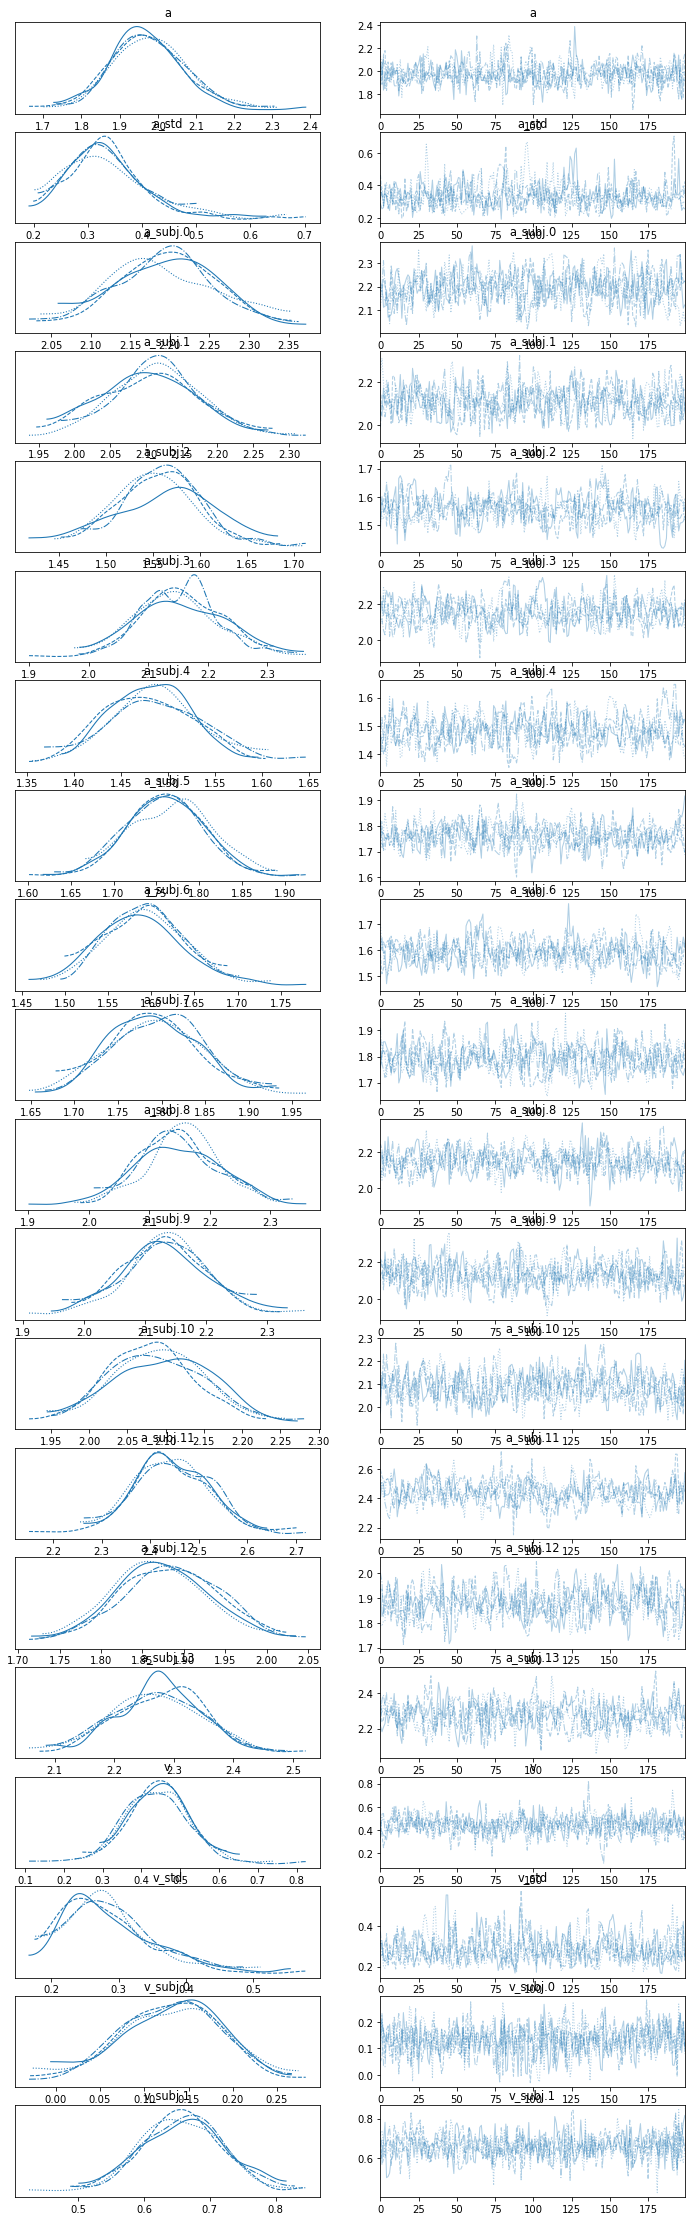

In [12]:
# from arviz.utils import Numba
# Numba.disable_numba()
# Numba.numba_flag
az.plot_trace(InfData['ms0'])

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

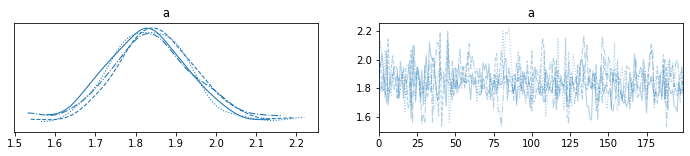

In [13]:
#     using regex to select var_names that start with "a" 
# and do not contain either "subj" or "std"

az.plot_trace(InfData['ms4'], var_names=("^a(?!.*(subj|std))"), filter_vars='regex')

#### Using `az.summary()` to check $\hat{R}$ and ESS

In [14]:
ms0_summary = az.summary(InfData['ms0'])
ms0_summary.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_subj.13,0.525,0.028,0.468,0.570,0.001,0.001,368.0,404.0,1.00
v_subj.11,0.592,0.058,0.484,0.697,0.002,0.002,623.0,511.0,1.00
v_subj.10,0.575,0.063,0.458,0.700,0.002,0.002,783.0,531.0,1.00
v_subj.9,0.227,0.066,0.105,0.353,0.002,0.002,938.0,563.0,1.00
v_subj.8,0.493,0.062,0.366,0.596,0.002,0.002,755.0,627.0,1.00
v_subj.7,0.031,0.069,-0.091,0.159,0.002,0.002,777.0,570.0,1.00
t_subj.0,0.554,0.030,0.501,0.619,0.002,0.001,371.0,507.0,1.00
v_subj.4,0.946,0.095,0.756,1.116,0.004,0.003,679.0,579.0,1.00
v_subj.3,0.164,0.061,0.052,0.279,0.002,0.002,756.0,559.0,1.00
v_subj.1,0.659,0.063,0.547,0.779,0.002,0.002,675.0,582.0,1.00


In [15]:
ms4_summary = az.summary(InfData['ms4'])
ms4_summary.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_subj.0,2.061,0.070,1.925,2.183,0.005,0.003,239.0,486.0,1.00
a,1.844,0.113,1.634,2.061,0.005,0.004,525.0,511.0,1.01
t_subj.2,0.599,0.020,0.563,0.636,0.002,0.001,163.0,205.0,1.01
v_Intercept_subj.2,0.968,0.122,0.745,1.205,0.009,0.006,194.0,472.0,1.01
v_Intercept,0.761,0.114,0.574,1.010,0.006,0.005,305.0,477.0,1.01
...,...,...,...,...,...,...,...,...,...
sz,0.122,0.098,0.001,0.323,0.022,0.017,30.0,27.0,1.11
z_subj_trans.8,0.046,0.055,-0.061,0.148,0.011,0.008,28.0,78.0,1.11
z_trans,0.034,0.032,-0.029,0.095,0.006,0.005,30.0,55.0,1.11
z_subj_trans.10,0.081,0.071,-0.037,0.218,0.019,0.014,14.0,69.0,1.21


### Model comparison and selection

#### DIC

In [16]:
%%time

tmp_dic = []
indx_name = []
for m_key, model in models.items():
#     print(len(models[key]))
    m_tmp = kabuki.utils.concat_models(model)
    tmp_dic.append(m_tmp.dic)
    indx_name.append(m_key)
#     print(m_key + "'s DIC: ", m_tmp.dic) # model 4 has the lowest DIC
    
comp_dic = pd.DataFrame(tmp_dic, index=indx_name, columns=['dic'])
comp_dic = comp_dic.sort_values(by=['dic'])
comp_dic = comp_dic.reset_index()
comp_dic.rename(columns={'index':'rank'}, inplace=True)
comp_dic

CPU times: user 2.69 s, sys: 0 ns, total: 2.69 s
Wall time: 2.69 s


,rank,dic
0,ms4,10654.801947
1,ms0,10976.562332


#### PSIS-LOO-CV

In [17]:
comp_loo = az.compare(InfData, ic='loo')
comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
ms4,0,-6326.532081,922.505292,0.000000,0.802213,420.211397,0.000000,True,log
ms0,1,-9358.726728,3842.071227,3032.194647,0.197787,1228.817194,1273.110346,True,log


####  WAIC

In [18]:
comp_waic = az.compare(InfData, ic='waic')
comp_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
ms4,0,-13711.735424,8307.708634,0.000000,0.799349,4357.552486,0.000000,True,log
ms0,1,-42148.057651,36631.402149,28436.322227,0.200651,13138.437468,13779.754179,True,log


#### Posterior predictive check

array([<AxesSubplot:xlabel='rt / rt'>,
       <AxesSubplot:xlabel='response / response'>], dtype=object)

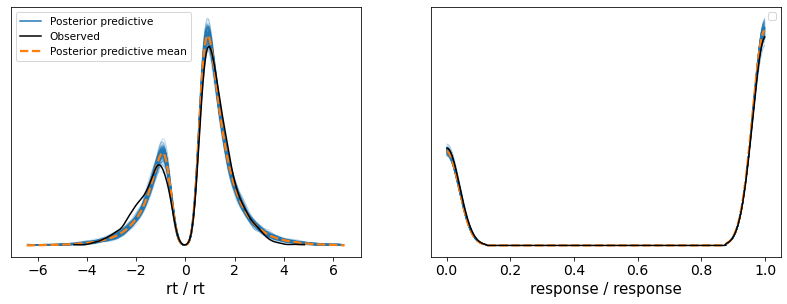

In [19]:
az.plot_ppc(InfData['ms0'])

array([<AxesSubplot:xlabel='rt / rt'>,
       <AxesSubplot:xlabel='response / response'>], dtype=object)

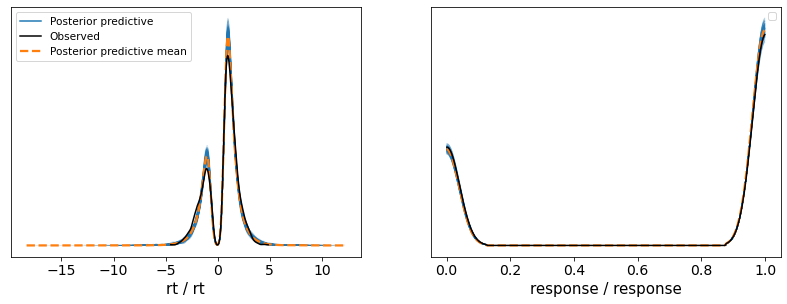

In [20]:
az.plot_ppc(InfData['ms4'])

In [21]:
from plot_ppc_by_cond import plot_ppc_by_cond

[3, 'HC', 1]
[3, 'LC', 1]
[3, 'LC', 0]
[3, 'HC', 0]


array([[<AxesSubplot:xlabel='rt / rt\nsubj_3, conf_HC, dbs_1'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, conf_LC, dbs_1'>],
       [<AxesSubplot:xlabel='rt / rt\nsubj_3, conf_LC, dbs_0'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, conf_HC, dbs_0'>]],
      dtype=object)

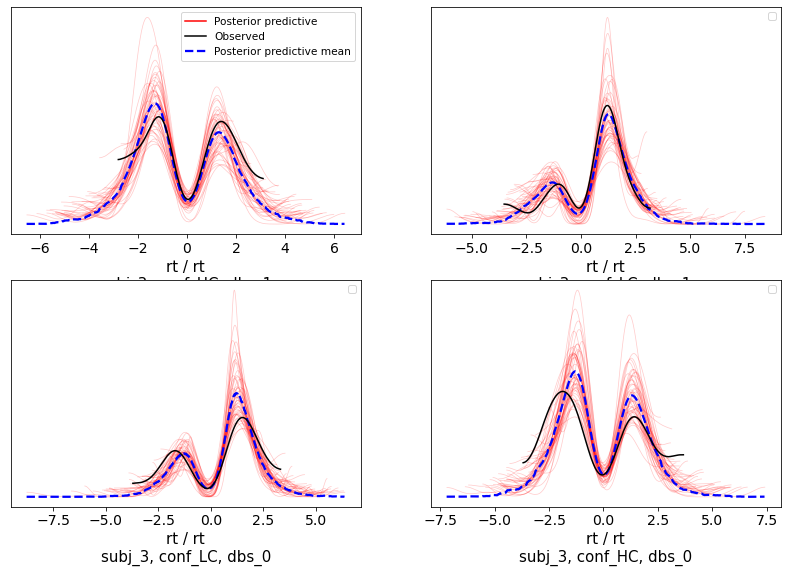

In [22]:
plot_ppc_by_cond(data = InfData['ms4'],
                 or_d = data_cavanagh,
                 subjs = [3],
#                  conds = ['conf'],
                 conds = ['conf','dbs'],
                 colors = ['r', 'k', 'b'],
                 num_pp_samples=100,
                 random_seed = 7,
                 alpha = 0.2,
                 grid = [2,2],
                 var_names=['rt'])

[3, 'HC', 1]
[3, 'LC', 1]
[3, 'LC', 0]
[3, 'HC', 0]


array([[<AxesSubplot:xlabel='rt / rt\nsubj_3, conf_HC, dbs_1'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, conf_LC, dbs_1'>],
       [<AxesSubplot:xlabel='rt / rt\nsubj_3, conf_LC, dbs_0'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, conf_HC, dbs_0'>]],
      dtype=object)

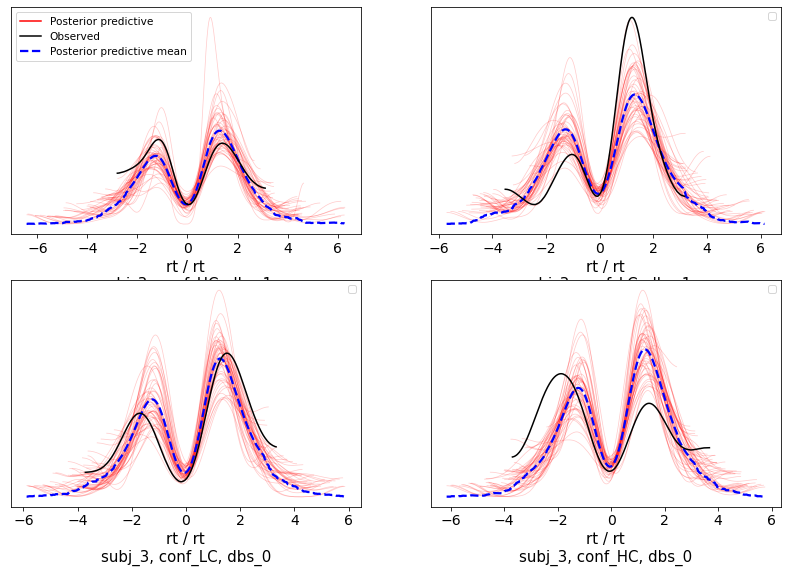

In [23]:
plot_ppc_by_cond(data = InfData['ms0'],
                 or_d = data_cavanagh,
                 subjs = [3],
#                  conds = ['conf'],
                 conds = ['conf','dbs'],
                 colors = ['r', 'k', 'b'],
                 num_pp_samples=100,
                 random_seed = 7,
                 alpha = 0.2,
                 grid = [2,2],
                 var_names=['rt'])

## Statistical Inference

array([[<AxesSubplot:title={'center':'v_Intercept'}>,
        <AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

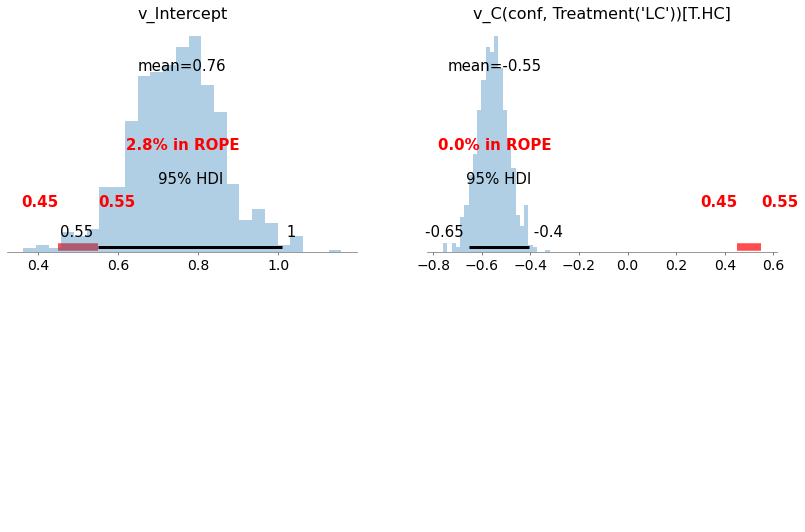

In [24]:
# using regex to select var_names that start with "a_theta" and do not contain either "subj" or "std"
az.plot_posterior(InfData['ms4'], 
                  var_names=("^v_(?!.*(subj|std))"), 
                  filter_vars='regex',
                  grid = [2, 2], 
                  kind = 'hist',
                  hdi_prob = 0.95,
                  rope = [0.45, 0.55], 
                  rope_color = 'r')